# Sizing of pods' CPU request - preprod / analyzer-worker-data

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib ipympl
import matplotlib.pyplot as plt
import numpy as np
from stats.stats_service import StatsService

## Load a time series from disk

In [2]:
stats_service = StatsService(name="CPU usage")
stats_service.load_time_series(path="data/analyzer-worker-data/cpu_usage-60d.json")

## Signal processing
- Smoothing with the _moving average_ approach
  - `window_size=11` means an averaging window of 10 time steps, that is 300s
- Flooring of lower values
  - The threshold is set to 100 mCPU in order to remove the noise when the worker is inactive

In [3]:
from stats import smoothing
# cpu_threshold = stats_service.percentiles(95)[0]
# print(f"floor CPU threshold: {cpu_threshold*1000} mCPU")
cpu_threshold = 100e-3
stats_service.smooth(algo_type=smoothing.Method.MOVING_AVG, window_size=11).floor(threshold=cpu_threshold);

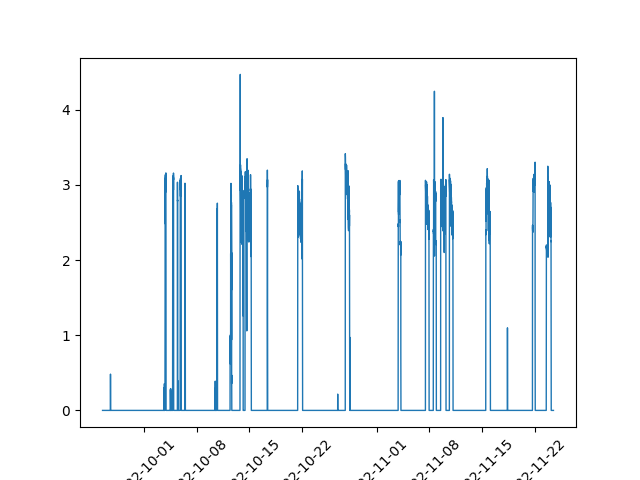

In [4]:
fig, ax = plt.subplots()
ax.plot(stats_service.time_series.time, stats_service.time_series.resource, linewidth=1.0)
plt.xticks(rotation = 45)
plt.show()

## CPU Peak values

In [5]:
# Find peaks
peaks = stats_service.get_peaks()

In [6]:
# Test peak filtering by threshold
# peaks.datetimes(threshold=3300e-3)

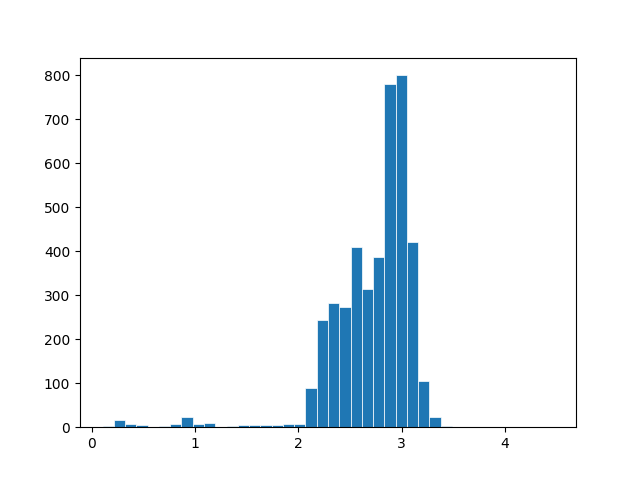

In [7]:
peaks.plots.histogram(bins=40)

## Percentiles
### Non-parametric
The percentiles are computed with a **non-parametric** approach. The assessment is not sensitive to the numerical method.

💡 These non-parametric approach are bounded to the sample range. Using a distribution model would allow a more "robust" result, given a proper determination of the model.

In [8]:
import pandas as pd
percents = [90,95, 99]
methods = [
    "linear",
    "inverted_cdf",
    "averaged_inverted_cdf",
    "closest_observation",
    "interpolated_inverted_cdf",
    "hazen",
    "weibull",
    "median_unbiased",
    "normal_unbiased",
    "lower",
    "higher",
    "midpoint",
    "nearest",
]

records = []
for method in methods:
    percentile_res = peaks.percentiles(percents, method=method)
    records.append({f"q-{perc_val}": quant_val for perc_val, quant_val in zip(percents, percentile_res)})
    
df = pd.DataFrame(records, index=methods)
display(df)

,q-90,q-95,q-99
linear,3.082100,3.136112,3.227595
inverted_cdf,3.082202,3.136290,3.228005
averaged_inverted_cdf,3.082202,3.136290,3.228005
closest_observation,3.082202,3.135994,3.227216
interpolated_inverted_cdf,3.082049,3.136097,3.227587
hazen,3.082248,3.136246,3.227981
weibull,3.082338,3.136404,3.228877
median_unbiased,3.082278,3.136290,3.228258
normal_unbiased,3.082270,3.136279,3.228180
lower,3.081692,3.135994,3.227216


# Conclusion
A global request of 3220 mCPU seems OK. The _max pods_ settings of HPA being 2, it means an average request of 1610 mCPU.
Besides, the result is stable for ranges of 30 to 60 days in the past. The global usage for data monitored on the last 30 days is $q_{99\%}$ = 3250 mCPU.